In [39]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tif
import sys
import os
import time

In [32]:
utils_path = '../../../mesoSPIM/src/'
if os.path.exists(utils_path):
    sys.path.append('../../../mesoSPIM/src/')
else:
    print('Error: check your path to utils module')

In [34]:
from utils import optimization as opt

In [40]:
# iDisco mouse brain from Anna-Maria-Reuss
img_folder = '../fixtures/defocus/'
exp_files = {'left_488': 'zstep1_Fstep10_488_nm_1x_Left_crop400',
              'right_488': 'zstep1_Fstep10_488_nm_1x_Right_crop400',
              'left_561': 'zstep1_Fstep10_561_nm_1x_Left_crop400',
              'right_561': 'zstep1_Fstep10_561_nm_1x_Right_crop400',
            }

In [41]:
stack = tif.imread(img_folder + exp_files['left_488'] + '.tif')

Text(0.5, 1.0, 'Image off the focus (+200 um)')

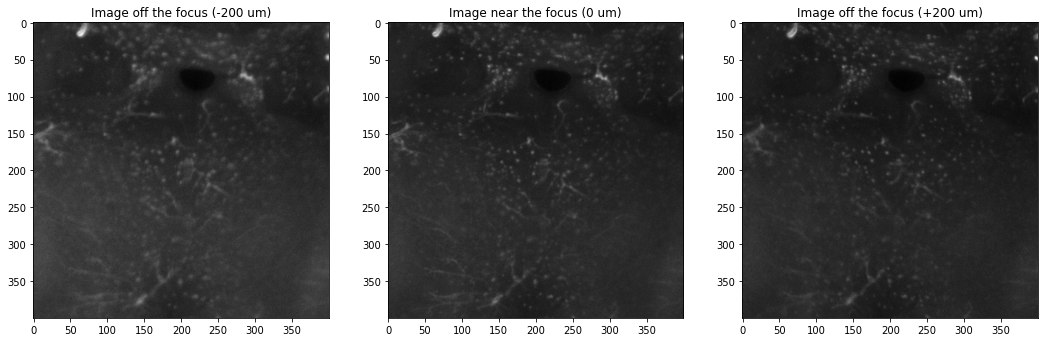

In [61]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(stack[0,:,:], cmap='gray')
plt.title("Image off the focus (-200 um)")

plt.subplot(1, 3, 2)
plt.imshow(stack[10,:,:], cmap='gray')
plt.title("Image near the focus (0 um)")

plt.subplot(1, 3, 3)
plt.imshow(stack[-1,:,:], cmap='gray')
plt.title("Image off the focus (+200 um)")

In [44]:
%%time
expt_dcts = {}
for key in exp_files:
    stack = tif.imread(img_folder + exp_files[key] + '.tif')
    expt_dcts[key] = []
    for z in range(stack.shape[0]):
        expt_dcts[key].append(opt.shannon_dct(stack[z,:,:]))

Wall time: 477 ms


In [62]:
%%timeit
opt.shannon_dct(stack[20,:,:])

2.67 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0, 0.5, 'DCTS, a.u.')

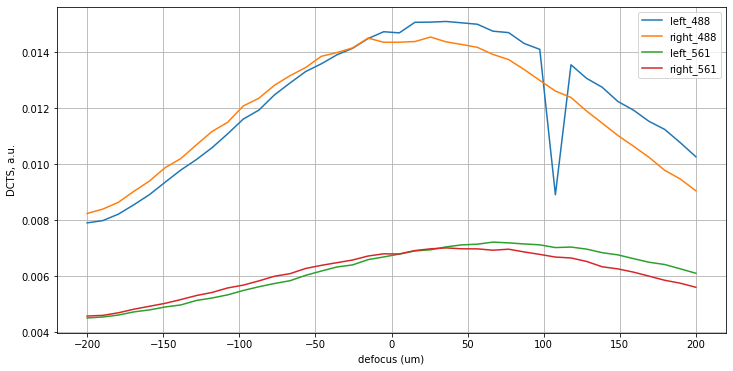

In [56]:
plt.figure(figsize=(12,6))
defocus_um = np.linspace(-200, 200, stack.shape[0])
for key in expt_dcts:
    plt.plot(defocus_um, expt_dcts[key], label=key)
plt.grid(True)
plt.legend()
plt.xlabel('defocus (um)')
plt.ylabel('DCTS, a.u.')

### Things to note
- DCTS gives a decent dynamic range on this data. This does not mean it is calculated mathematically correctly, but good enough for practical purposes.
- DCTS is calculated fast: for 400x400px images, it takes ~3 ms/image.
- The eye-balled focus position $z=0$ is off by about 10 um from true shapness maximum (using right 488 ch)
- Although the system is aligned (left vs right arm), there is a noticeable difference in focus between arms, about 30 um. It is very difficult if not impossible to spot this difference by eye, looking at the raw image.
- The z-stage (Galil) made a hickup when moving through left-488 stack.
- due to noise and possible stage hickups, a grid search with interpolation (following Royer et al, 2016) is probably the safest way to proceed.